In [1]:
!pip install boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.6 MB/s eta 0:00:00


In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import optuna
from optuna.exceptions import TrialPruned
%matplotlib inline
sns.set()
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
import joblib

In [5]:
df = pd.read_csv('/content/home-listings-example.csv')

In [6]:
X,X_val,y,y_val = train_test_split(df[~df['ClosePrice'].isnull()][['CurrentPrice','CoListAgentMLSID','ListPrice','LotSizeArea','LotSizeAreaSQFT','OriginalListPrice','RATIO_CurrentPrice_By_SQFT','SqFtTotal','UnexemptTaxes','ElementarySchoolName']],df[~df['ClosePrice'].isnull()].ClosePrice,test_size=0.2,random_state=42)

In [7]:
fill_nan_defaults = {"numerical": -999 ,"categorical":'null',"ignored" : "null"}

In [8]:
float_features =['CurrentPrice','CoListAgentMLSID','ListPrice','LotSizeArea','LotSizeAreaSQFT','OriginalListPrice','RATIO_CurrentPrice_By_SQFT','SqFtTotal','UnexemptTaxes']
categorical_features = ['ElementarySchoolName']

In [9]:
numeric_transformer = Pipeline([('imputer1', SimpleImputer(strategy='constant',fill_value=fill_nan_defaults['numerical'])),
                               ])


categorical_transformer = Pipeline([
 ('imputer' ,SimpleImputer(strategy='constant',missing_values=np.nan,fill_value=fill_nan_defaults['categorical'])),
  ('dummies',OneHotEncoder(handle_unknown='ignore'))
  ])



ColumnPreprocessor = ColumnTransformer(
    transformers=[
    #    ("ignored", ignored_transformer, ignored_features),
        ("num", numeric_transformer, float_features),
       ("cat", categorical_transformer, categorical_features),
    ]
)

In [10]:
X_pre = ColumnPreprocessor.fit_transform(X,y)
X_val_pre = ColumnPreprocessor.transform(X_val)
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size=0.5, random_state=42)

In [11]:
def objective(trial):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 10, 200, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    # Create and fit random forest model
    model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42,
    )
    model.fit(X_train, y_train)

    # Make predictions and calculate RMSE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Return MAE
    return mae

In [12]:
study = optuna.create_study(direction="minimize")


[I 2023-10-08 20:41:37,345] A new study created in memory with name: no-name-1eba50f4-c25b-45d0-b983-80750f3d0b8e


In [13]:
# Run optimization process
study.optimize(objective, n_trials=50, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-08 20:41:39,134] Trial 0 finished with value: 53015.35703253727 and parameters: {'n_estimators': 117, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 53015.35703253727.
[I 2023-10-08 20:41:39,191] Trial 1 finished with value: 32795.0990027598 and parameters: {'n_estimators': 52, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 1 with value: 32795.0990027598.
[I 2023-10-08 20:41:39,360] Trial 2 finished with value: 24916.851307941004 and parameters: {'n_estimators': 168, 'max_depth': 31, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 2 with value: 24916.851307941004.
[I 2023-10-08 20:41:39,387] Trial 3 finished with value: 30140.831379218434 and parameters: {'n_estimators': 12, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 2 with value: 24916.851307941004.
[I 2023-10-08 20:41:39,425] Trial 4 finished with value: 43655.10964091509 and parameters: {'n_e

In [14]:
# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)

Best trial: FrozenTrial(number=12, state=TrialState.COMPLETE, values=[22000.395227614965], datetime_start=datetime.datetime(2023, 10, 8, 20, 41, 40, 275271), datetime_complete=datetime.datetime(2023, 10, 8, 20, 41, 40, 504216), params={'n_estimators': 194, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=200, log=True, low=10, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=12, value=None)
Best hyperparameters: {'n_estimators': 194, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [15]:
selected_params = {k:v for (k,v) in study.best_params.items()}
selected_params

{'n_estimators': 194,
 'max_depth': 15,
 'min_samples_split': 2,
 'min_samples_leaf': 1}

In [16]:
model = RandomForestRegressor(**selected_params,verbose=0)
model.fit(X_pre,y)

RandomForestRegressor(max_depth=15, n_estimators=194)

In [17]:
pipe = Pipeline(steps=[('ColumnPreprocessor', ColumnPreprocessor),
                      ('classifier', model)])

In [18]:
dummy_cols = pipe.named_steps['ColumnPreprocessor'].transformers_[1][1].named_steps['dummies'].get_feature_names_out(categorical_features).tolist()
cols_tr =  float_features
column_names = cols_tr+dummy_cols
X_final= pd.DataFrame(X_pre)
X_final.columns = column_names

<BarContainer object of 30 artists>

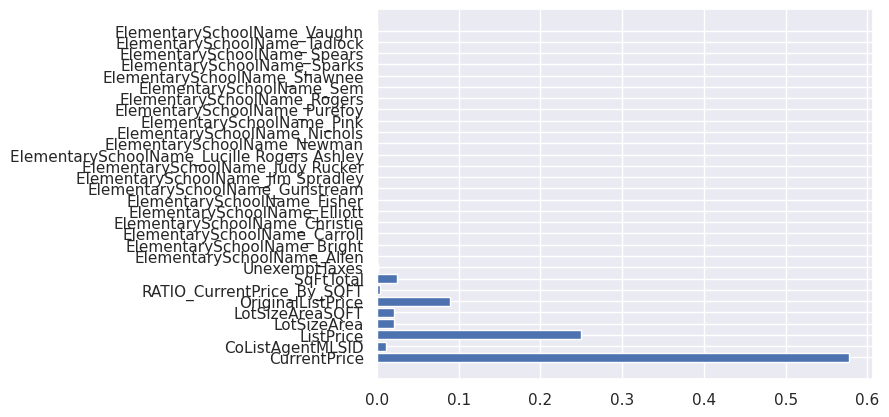

In [19]:
plt.barh(X_final.columns, model.feature_importances_)


In [20]:
joblib.dump(pipe,'model.pkl')

['model.pkl']

In [21]:
y_pred = pipe.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

In [22]:
rmse,mae,r2

(10641.589123461445, 2719.291266072052, 0.9971879100759266)

In [23]:
y_pred = pipe.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

In [24]:
rmse,mae,r2

(5071.509006390681, 3153.8014891179814, 0.999217700380946)

In [ ]:
#TODO : Understand why the RMSE is changing so much compared to MAE